# Backtesting ETH with a Bollinger Bands strategy

Still simple stuff, but I keep going forward

## imports

In [1]:
import backtrader as bt
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, DateFormatter
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import backtrader.feeds as btfeeds

Load data_feed of ETH as usual

In [2]:
data_feed_2 = btfeeds.GenericCSVData(
    dataname="/Users/leonardoplacidi/Desktop/BacktestingTrade/Python4Finance/data/Bybit_ETH_for_backtesting_IV.csv",
    #fromdate=datetime(2024, 1, 1), 
    #todate=datetime(2024, 5, 24),
    nullvalue=0.0,
    dtformat=('%Y-%m-%d'),
    datetime=0,
    high=2,
    low=3,
    open=1,
    close=4,
    volume=5,
    openinterest=8
)

Strategy, when it crosses the upper BB buy, when it crosses down sell. No short selling atm.

In [3]:
# Create a Stratey
class BollingerBands_simple_Strategy(bt.Strategy):
    params = (
        ('period', 20),
        ('dev', 2.0),
        ('printlog', False)
    )

    def log(self, txt, dt=None, doprint = False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.cumulative_pnl = 0.0
        
        self.end_of_data = False

        # Add BB indicator
        self.b_band = bt.indicators.BollingerBands(self.datas[0], period = self.p.period, devfactor = self.p.dev)
       #self.b_band.plotinfo.plotname = 'BB'
        self.buy_signal = bt.indicators.CrossOver(self.datas[0], self.b_band.lines.bot)
        self.buy_signal.plotinfo.plotname = 'buy signal'
        self.sell_signal = bt.indicators.CrossOver(self.datas[0], self.b_band.lines.top)
        self.sell_signal.plotinfo.plotname = 'sell signal'
        # Indicators for the plotting show
        

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm), doprint = True)

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm), doprint = True)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled]:
            self.log('Order Canceled', doprint = True)
        elif order.status in [order.Margin]:
            self.log('Order Margin', doprint = True)
        elif order.status in [order.Rejected]:
            self.log('Order Rejected', doprint = True)
            
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
        self.cumulative_pnl += trade.pnlcomm

    def next_open(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])
        
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return
        
        if not self.position:
            
            # Not yet ... we MIGHT BUY if ...
            if self.buy_signal > 0: #crosses upward = 1
                size = int(self.broker.getcash() / (self.datas[0].open)) # buy full based on next day
                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0], doprint = True)
                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy(size = size)

        else:
            if self.sell_signal < 0: #crosses downward = 1
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0], doprint = True)
                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell(size = self.position.size)
        
                
    def stop(self):   
        #self.log("SMA period %d" % self.params.maperiod, doprint=True)
        self.log('Cumulative PnL %.2f' % self.cumulative_pnl,  doprint=True)

In [5]:
cerebro = bt.Cerebro(stdstats = False, cheat_on_open = True) #(stdstats = False)this disables the 3 observers for the trades
# Add a strategy
cerebro.addstrategy(BollingerBands_simple_Strategy, period = 20, dev = 2.0)

##optimize!
#cerebro.optstrategy(
#        TestStrategy,
#        maperiod=range(10, 31))

cerebro.adddata(data_feed_2)

cerebro.broker.setcash(10000.0)
 # Add a FixedSize sizer according to the stake *I wanna buy 2 ETH cauze I feel rich and not a poor student sigh...
#cerebro.addsizer(bt.sizers.FixedSize, stake=2)
# Set the commission - 0.1% ... divide by 100 to remove the %
cerebro.broker.setcommission(commission=0.001)

print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}') 
cerebro.run() 
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')
print("End :)")

Starting Portfolio Value: 10000.00
2024-03-21, BUY CREATE, 3494.05
2024-03-21, BUY EXECUTED, Price: 3518.45, Cost: 7036.90, Comm 7.04
2024-05-24, Cumulative PnL 0.00
Final Portfolio Value: 10413.26
End :)


In [4]:
%matplotlib inline

/Users/leonardoplacidi/opt/anaconda3/envs/BT/lib/python3.9/site-packages/backtrader/plot/locator.py:184: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 14.
  warnings.warn('AutoDateLocator was unable to pick an '


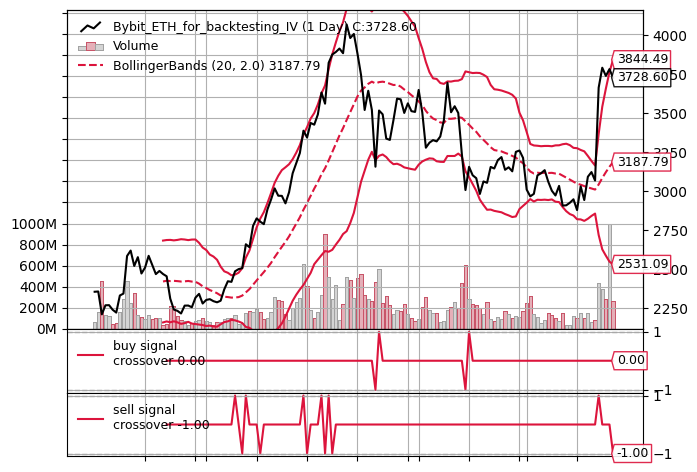

In [7]:
# Plotting
%matplotlib inline
fig = cerebro.plot(iplot=False)[0][0]

# Customize the x-axis date format
locator = AutoDateLocator()
formatter = DateFormatter('%Y-%m-%d')
ax = fig.get_axes()[0]  # Get the first (and only) axis
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
fig.autofmt_xdate()

plot_path = "/Users/leonardoplacidi/Desktop/BacktestingTrade/Python4Finance/some_plots/eth_BB.png"  # Replace with your desired folder path
fig.savefig(plot_path, bbox_inches='tight')

plt.show()